# Red neuronal para predecir poses

## Importar librerias

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import tensorflow as tf
from keras import layers,callbacks
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

tf.config.list_physical_devices('GPU')
print(tf.test.is_built_with_cuda(), tf.test.is_gpu_available())

True False


## Preparar datos

In [3]:
DATA      = Path("../data").resolve()
TRAIN_VAL = DATA / "train_val_csv"
TEST      = DATA / "test_csv"
Salida    = Path("dataset_completo.csv")
#
# Unir los csvs de entrenamiento para hacer uno solo
def une_csvs(carpeta):
    csvs = [p for p in DATA.rglob("*.csv") if p.parent==carpeta and p.stem!=Salida.stem]
    df =pd.concat((pd.read_csv(f) for f in csvs),ignore_index=True)
    df = df.drop_duplicates().reset_index(drop=True)
    df.to_csv(carpeta/Salida, index=False, float_format="%.6f")

    x= df.drop(columns=['label'])
    y= df['label']
    y_one_hot =poses_lb.fit_transform(y)
    return df,x,y,y_one_hot
#
poses_lb   =LabelBinarizer()
#
df_train_val,X_train_val,Y_train_val,Y_oh_train_val=une_csvs(TRAIN_VAL)
#
df_test, X_test, Y_test, Y_oh_test=une_csvs(TEST)

print(Y_oh_train_val,Y_train_val)

print(Y_oh_test,Y_test)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]] 0                 OTRO
1                 OTRO
2                 OTRO
3                 OTRO
4                 OTRO
             ...      
2080    POSICION_FETAL
2081    POSICION_FETAL
2082    POSICION_FETAL
2083    POSICION_FETAL
2084    POSICION_FETAL
Name: label, Length: 2085, dtype: object
[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]] 0                 OTRO
1                 OTRO
2                 OTRO
3                 OTRO
4                 OTRO
             ...      
1461    POSICION_FETAL
1462    POSICION_FETAL
1463    POSICION_FETAL
1464    POSICION_FETAL
1465    POSICION_FETAL
Name: label, Length: 1466, dtype: object


## Preparar datos (Test)

## Dividir datos en:
* Entrenamiento = 80%
* Validación = 20%

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, Y_oh_train_val, test_size=0.20, stratify=Y_train_val, random_state=42)

## Definicion y compilacion de Red Neuronal

In [5]:
n_features = X_train.shape[1]
n_classes  = y_train.shape[1]
#print(n_features,n_classes)
#
model = Sequential([
    layers.Input( shape=(n_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(n_classes, activation='softmax')
])
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

## Entrenamiento

In [6]:
model_path = Path ("../models").resolve()
models = [p for p in model_path.rglob("best_model*.keras")]
model_name = str(model_path / f'best_model_{len(models)}.keras')


checkpoint = callbacks.ModelCheckpoint(
    model_name, save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=2)


Epoch 1/100
7/7 - 1s - 181ms/step - accuracy: 0.4922 - loss: 1.4004 - val_accuracy: 0.2326 - val_loss: 1.4054
Epoch 2/100
7/7 - 0s - 18ms/step - accuracy: 0.7764 - loss: 0.6589 - val_accuracy: 0.2518 - val_loss: 1.3771
Epoch 3/100
7/7 - 0s - 18ms/step - accuracy: 0.8357 - loss: 0.4859 - val_accuracy: 0.2830 - val_loss: 1.3490
Epoch 4/100
7/7 - 0s - 18ms/step - accuracy: 0.8969 - loss: 0.3426 - val_accuracy: 0.3094 - val_loss: 1.3270
Epoch 5/100
7/7 - 0s - 18ms/step - accuracy: 0.8999 - loss: 0.3020 - val_accuracy: 0.3070 - val_loss: 1.3038
Epoch 6/100
7/7 - 0s - 19ms/step - accuracy: 0.9215 - loss: 0.2410 - val_accuracy: 0.3285 - val_loss: 1.2754
Epoch 7/100
7/7 - 0s - 19ms/step - accuracy: 0.9251 - loss: 0.2404 - val_accuracy: 0.3717 - val_loss: 1.2214
Epoch 8/100
7/7 - 0s - 19ms/step - accuracy: 0.9347 - loss: 0.1936 - val_accuracy: 0.4388 - val_loss: 1.1524
Epoch 9/100
7/7 - 0s - 20ms/step - accuracy: 0.9347 - loss: 0.1873 - val_accuracy: 0.4676 - val_loss: 1.0959
Epoch 10/100
7/7 -

## Evaluación

In [7]:
models = [p for p in model_path.rglob("best_model*.keras")]
for model in models:
    modelName=str(model)
    print(f'\n\n Modelo: {model.stem}')
    best_model = load_model(modelName)
    test_loss, test_acc = best_model.evaluate(X_test, Y_oh_test, verbose=0)
    print(f"Accuracy en test: {test_acc:.3f}")


    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(Y_oh_test.argmax(1), y_pred.argmax(1))
    print(cm)
    print(classification_report(Y_oh_test.argmax(1), y_pred.argmax(1), target_names=poses_lb.classes_))



 Modelo: best_model_13


I0000 00:00:1754796774.449984   16946 service.cc:152] XLA service 0x7d988805b400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754796774.450016   16946 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-08-09 21:32:54.478809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754796774.623719   16946 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Accuracy en test: 0.945
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[349   5   0   0]
 [  0 383   0   0]
 [  1  35 451   0]
 [ 20  12   7 203]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.94      0.99      0.96       354
         FIRMES       0.88      1.00      0.94       383
           OTRO       0.98      0.93      0.95       487
 POSICION_FETAL       1.00      0.84      0.91       242

       accuracy                           0.95      1466
      macro avg       0.95      0.94      0.94      1466
   weighted avg       0.95      0.95      0.95      1466



 Modelo: best_model_16
Accuracy en test: 0.945
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[351   3   0   0]
 [  1 382   0   0]
 [  9  26 452   0]
 [ 33   3   6 200]]
                 precision    recall  f1-score   support

BRAZOS_CRUZADOS       0.89      0.99      0.94       354
         FIRMES       0.92      1.00      0.96       383
           OTRO       0.99      0.93      0.96       487
 POSICI

## Graficas de resultados

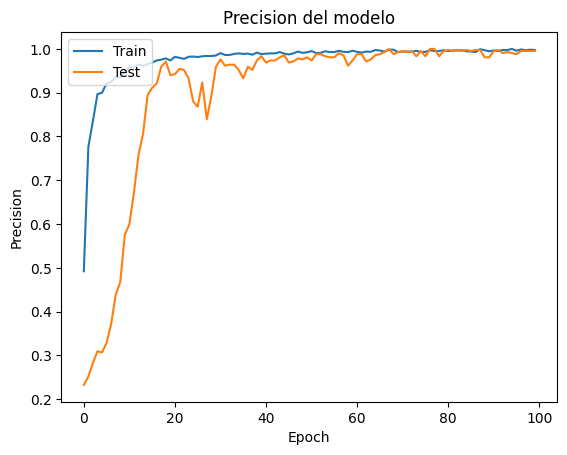

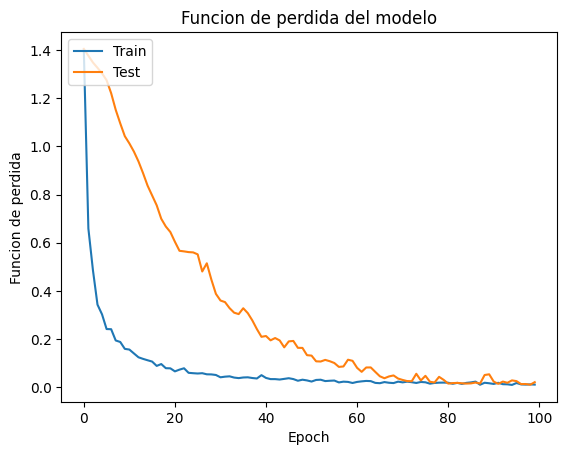

In [8]:
#Evaluar resultados
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precision del modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Funcion de perdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Funcion de perdida del modelo')
plt.ylabel('Funcion de perdida')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Uso del modelo para predicción

In [ ]:
from scripts.ExtraeFrame import IMAGEN

imagen=IMAGEN("Fotos/foto1.png")
x_new=imagen.extrae(muestra=True)
x_new=np.array([x_new])

prediccion  = best_model.predict(x_new)
print (prediccion)
print (np.argmax(prediccion, axis=1))
label  = poses_lb.inverse_transform(prediccion)
print(label)

Analizando Imagen


I0000 00:00:1754796797.581311    7225 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754796797.585090   33904 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1754796797.651201   33870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754796797.740510   33885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754796797.802348   33878 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/misa/yes/envs/timelessTuring/li

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
[[9.3269703e-10 9.5857865e-01 4.1418198e-02 3.2549160e-06]]
['FIRMES']


In [ ]:
from scripts.ExtraeFrame import VideoPrediccion
best_model=load_model("/home/misa/GitHub/Timeless-Turing/models/best_model_7.keras")
prueba1 = VideoPrediccion("/home/misa/GitHub/Timeless-Turing/data/processed_videos/Gaby_2.mp4")
prueba1.AnalizaVideo(best_model,poses_lb, csv_path="Gaby_2.csv", step=3,reproduce=True)

Iniciando analisis de Video:
Analizando Imagen


I0000 00:00:1754796801.668365    7225 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1754796801.672004   34045 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) Graphics (RPL-S)
W0000 00:00:1754796801.728160   34010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1754796801.835277   34035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
OTRO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
OTRO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
BRAZOS_CRUZADOS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
OTRO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
OTRO
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
FIRMES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
FIRMES